## k-step hypergraphs

In [1]:
import pickle
import numpy as np
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from itertools import product, permutations
from collections import defaultdict
from copy import copy

import scienceplots

plt.style.use(['science'])
plt.rcParams['svg.fonttype'] = 'none'

from useful_functions import *
from tensor_functions import *

In [2]:
corr = "spearman"

In [3]:
def findPaths(G,u,k):
    if k == 0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) for path in findPaths(G,neighbor,k-1)]
    return paths


In [4]:
def to_step_tensor(G, k):
    
    tensor_dict = defaultdict(lambda: 0)
    
    for node in G.nodes:
        
        for hyperedge in findPaths(G,node,k-1):
            
            tensor_dict[tuple(hyperedge)] += 1
        
    return dict(tensor_dict), tuple([len(G.nodes)]*k)

In [5]:
if corr == "kendall":
    correlation = scipy.stats.kendalltau
elif corr == "spearman":
    correlation = scipy.stats.spearmanr

## Test

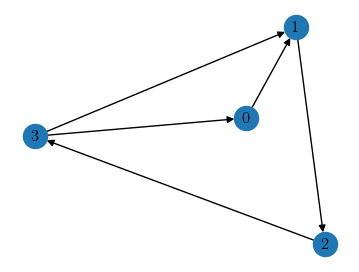

In [7]:
G = nx.cycle_graph(4,create_using=nx.DiGraph)
G.add_edge(3,1)
nx.draw(G, with_labels=True)

In [8]:
findPaths(G, 0, 2), findPaths(G, 1, 2), findPaths(G, 2, 2), findPaths(G, 3, 2)

([[0, 1, 2]], [[1, 2, 3]], [[2, 3, 0], [2, 3, 1]], [[3, 0, 1], [3, 1, 2]])

In [8]:
T2 = to_step_tensor(G,2)
T2

({(0, 1): 1, (1, 2): 1, (2, 3): 1, (3, 0): 1, (3, 1): 1}, (4, 4))

In [9]:
EC = nx.eigenvector_centrality_numpy(G)

In [10]:
cent, converged = HEC_ours(T2, m=2, niter=100000, tol=1e-6, verbose=True)

HEC2 = {}
for i, c in enumerate(cent):
    HEC2[i] = c 

tau = correlation(list(EC.values()), list(HEC2.values())).statistic
print(tau)

Finished in 16 iterations.
0.0


In [11]:
T3 = to_step_tensor(G,3)
T3

({(0, 1, 2): 1,
  (1, 2, 3): 1,
  (2, 3, 0): 1,
  (2, 3, 1): 1,
  (3, 0, 1): 1,
  (3, 1, 2): 1},
 (4, 4, 4))

In [12]:
cent, converged = HEC_ours(T3, m=3, niter=100000, tol=1e-6, verbose=True)

HEC3 = {}
for i, c in enumerate(cent):
    HEC3[i] = c 
    
tau = correlation(list(EC.values()), list(HEC3.values())).statistic
print(tau)

Finished in 12 iterations.
0.3333333333333334


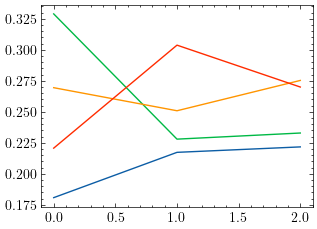

In [13]:
EC = {i:EC[i]/np.sum(list(EC.values())) for i in range(len(EC))}
HEC2 = {i:HEC2[i]/np.sum(list(HEC2.values())) for i in range(len(HEC2))}
HEC3 = {i:HEC3[i]/np.sum(list(HEC3.values())) for i in range(len(HEC3))}
for i in range(len(EC)):
    plt.plot([EC[i],HEC2[i],HEC3[i]])

## Some datasets

In [46]:
name = "opsahl-openflights"
with open(f"DirectedNets/{name}.pkl", 'rb') as f:
    G = pickle.load(f)
    
largest = max(nx.strongly_connected_components(G), key=len)
G = nx.subgraph(G,largest)

print(len(G), len(G.edges), nx.is_directed(G))

G = nx.convert_node_labels_to_integers(G, ordering="sorted")

2868 30404 True


In [47]:
# name = "opsahl-powergrid"
# with open(f"DirectedNets/{name}.pkl", 'rb') as f:
#     G = pickle.load(f)
    
# largest = max(nx.connected_components(G), key=len)
# G = nx.subgraph(G,largest)

# print(len(G), len(G.edges), nx.is_directed(G))

# G = nx.convert_node_labels_to_integers(G, ordering="sorted")

In [48]:
nx.is_strongly_connected(G)

True

In [49]:
T = to_step_tensor(G,3)

In [50]:
cent3, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC3 = {}
for i, c in enumerate(cent3):
    HEC3[i] = c 
    
converged

Finished in 17 iterations.


True

In [51]:
T = to_step_tensor(G,4)

KeyboardInterrupt: 

In [ ]:
cent4, converged = HEC_ours(T, m=4, niter=100000, tol=1e-6, verbose=True)

HEC4 = {}
for i, c in enumerate(cent4):
    HEC4[i] = c 
    
converged

In [ ]:
EC = nx.eigenvector_centrality_numpy(G)
correlation(list(EC.values()), list(HEC3.values())).statistic, correlation(list(EC.values()), list(HEC4.values())).statistic

In [44]:
KendalltopK_H3E = []
for k in range(1, len(HEC3)):
                        
    topk1 = topN(HEC3, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H3E.append(coeff)

KendalltopK_EH3 = []
for k in range(1, len(HEC3)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC3[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH3.append(coeff)

KendalltopK_H4E = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC4, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H4E.append(coeff)
    

KendalltopK_EH4 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC4[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH4.append(coeff)


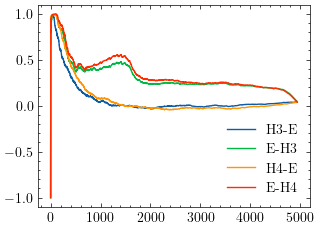

In [45]:
plt.plot(KendalltopK_H3E, label="H3-E")
plt.plot(KendalltopK_EH3, label="E-H3")
plt.plot(KendalltopK_H4E, label="H4-E")
plt.plot(KendalltopK_EH4, label="E-H4")

plt.legend()

#plt.savefig("Figures/k-step-comparison.png")

In [52]:
KendalltopK_H43 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC4, N=k)
    centrals2 = [HEC3[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H43.append(coeff)
    

KendalltopK_H34 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC3, N=k)
    centrals2 = [HEC4[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H34.append(coeff)

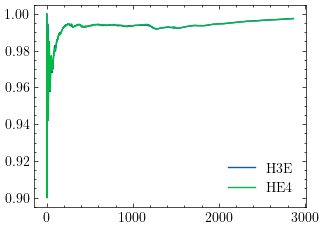

In [53]:
plt.plot(KendalltopK_H34, label="H3E")
plt.plot(KendalltopK_H43, label="HE4")

plt.legend()

In [ ]:
print(name)
ranking = {'HEC3':HEC3, 'HEC4':HEC4, 'EC':EC}

with open(f'CentralityData/Directed/cent_{name}.pkl', 'wb') as f:
    #pickle.dump(ranking, f)

## Final figures

### Load and recompute correlations

In [73]:
name1 = "tntp-ChicagoRegional"
with open(f'CentralityData/Directed/cent_{name}.pkl', 'rb') as f:
    ranking = pickle.load(f)
    
    HEC3_1 = ranking["HEC3"]
    HEC4_1 = ranking["HEC4"]
    EC_1 = ranking["EC"]
    
name2 = "subelj_euroroad"
with open(f'CentralityData/Directed/cent_{name}.pkl', 'rb') as f:
    ranking = pickle.load(f)
    
    HEC3_2 = ranking["HEC3"]
    HEC4_2 = ranking["HEC4"]
    EC_2 = ranking["EC"]
    
name3 = "opsahl-openflights"
with open(f'CentralityData/Directed/cent_{name}.pkl', 'rb') as f:
    ranking = pickle.load(f)
    
    HEC3_3 = ranking["HEC3"]
    HEC4_3 = ranking["HEC4"]
    EC_3 = ranking["EC"]
    

In [28]:
def compute_correlations(rank1, rank2, correlation=correlation):
    
    corr12 = []
    corr21 = []
    
    for k in range(1, len(rank1)):

        # 1->2
        topk1 = topN(rank1, N=k)
        centrals2 = [rank2[node] for node in topk1.keys()]

        coeff = correlation(list(topk1.values()), centrals2).statistic

        corr12.append(coeff)
        
        # 2->1        
        topk2 = topN(rank2, N=k)
        centrals1 = [rank1[node] for node in topk2.keys()]

        coeff = correlation(list(topk2.values()), centrals1).statistic

        corr21.append(coeff)
        
    return corr12, corr21

In [68]:
corrEH3_1, corrH3E_1 = compute_correlations(EC_1, HEC3_1)
corrEH4_1, corrH4E_1 = compute_correlations(EC_1, HEC4_1)
corrH3H4_1, corrH4H3_1 = compute_correlations(HEC3_1, HEC4_1)

corrEH3_2, corrH3E_2 = compute_correlations(EC_2, HEC3_2)
corrEH4_2, corrH4E_2 = compute_correlations(EC_2, HEC4_2)
corrH3H4_2, corrH4H3_2 = compute_correlations(HEC3_2, HEC4_2)

corrEH3_3, corrH3E_3 = compute_correlations(EC_3, HEC3_3)
corrEH4_3, corrH4E_3 = compute_correlations(EC_3, HEC4_3)
corrH3H4_3, corrH4H3_3 = compute_correlations(HEC3_3, HEC4_3)

In [74]:
all_corrs = {'names': {1:name1, 2:name2, 3:name3},
            'corrEH3_1':corrEH3_1, 'corrH3E_1':corrH3E_1, 'corrEH4_1':corrEH4_1,
            'corrH4E_1':corrH4E_1, 'corrH3H4_1':corrH3H4_1, 'corrH4H3_1':corrH4H3_1,
            'corrEH3_2':corrEH3_2, 'corrH3E_2':corrH3E_2, 'corrEH4_2':corrEH4_2,
            'corrH4E_2':corrH4E_2, 'corrH3H4_2':corrH3H4_2, 'corrH4H3_2':corrH4H3_2,
            'corrEH3_3':corrEH3_3, 'corrH3E_3':corrH3E_3, 'corrEH4_3':corrEH4_3,
            'corrH4E_3':corrH4E_3, 'corrH3H4_3':corrH3H4_3, 'corrH4H3_3':corrH4H3_3}

with open(f'CentralityData/Directed/all_correlations.pkl', 'wb') as f:
    #pickle.dump(all_corrs, f)

### Plot correlations

In [6]:
with open(f'CentralityData/Directed/all_correlations.pkl', 'rb') as f:
    all_corrs = pickle.load(f)
    
for key, val in all_corrs.items():
    globals()[key] = val

In [10]:
names

{1: 'tntp-ChicagoRegional', 2: 'subelj_euroroad', 3: 'opsahl-openflights'}

In [7]:
plt.rcParams['pdf.use14corefonts'] = True

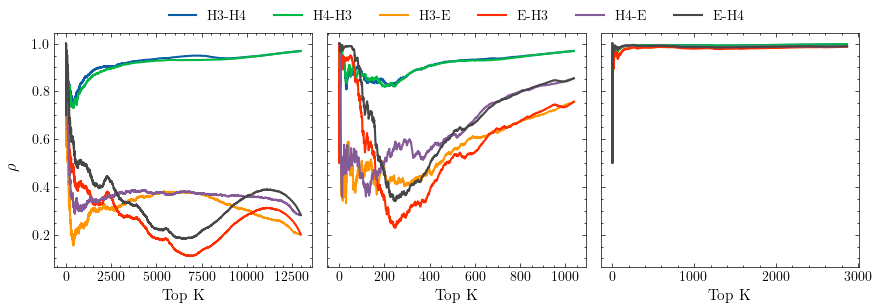

In [8]:
fig, ax = plt.subplots(1,3, figsize=(9,3), sharey=True)

fig.supylabel(r"$ \rho $")

ax[0].plot(corrH3H4_1, label="H3-H4", linewidth=1.5)
ax[0].plot(corrH4H3_1, label="H4-H3", linewidth=1.5)
ax[0].plot(corrH3E_1, label="H3-E", linewidth=1.5)
ax[0].plot(corrEH3_1, label="E-H3", linewidth=1.5)
ax[0].plot(corrH4E_1, label="H4-E", linewidth=1.5)
ax[0].plot(corrEH4_1, label="E-H4", linewidth=1.5)

ax[0].set_xlabel("Top K", fontsize=11)

ax[1].plot(corrH3H4_2, label="H3-H4", linewidth=1.5)
ax[1].plot(corrH4H3_2, label="H4-H3", linewidth=1.5)
ax[1].plot(corrH3E_2, label="H3-E", linewidth=1.5)
ax[1].plot(corrEH3_2, label="E-H3", linewidth=1.5)
ax[1].plot(corrH4E_2, label="H4-E", linewidth=1.5)
ax[1].plot(corrEH4_2, label="E-H4", linewidth=1.5)

ax[1].set_xlabel("Top K", fontsize=11)

ax[2].plot(corrH3H4_3, label="H3-H4", linewidth=1.5)
ax[2].plot(corrH4H3_3, label="H4-H3", linewidth=1.5)
ax[2].plot(corrH3E_3, label="H3-E", linewidth=1.5)
ax[2].plot(corrEH3_3, label="E-H3", linewidth=1.5)
ax[2].plot(corrH4E_3, label="H4-E", linewidth=1.5)
ax[2].plot(corrEH4_3, label="E-H4", linewidth=1.5)

ax[2].set_xlabel("Top K", fontsize=11)

plt.tight_layout()

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=False, shadow=False, ncol=6)


plt.savefig("Figures/k-step-comparison.svg")
plt.savefig("Figures/k-step-comparison.png")

In [56]:
name

'opsahl-openflights'

### 

## Test (undirected)

In [35]:
name = "opsahl-powergrid"
with open(f"DirectedNets/{name}.pkl", 'rb') as f:
    G = pickle.load(f)
    
largest = max(nx.connected_components(G), key=len)
G = nx.subgraph(G,largest)

print(len(G), len(G.edges), nx.is_directed(G))

G = nx.convert_node_labels_to_integers(G, ordering="sorted")

4941 6594 False


In [37]:
#nx.is_strongly_connected(G)

In [38]:
T = to_step_tensor(G,3)

In [39]:
cent3, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC3 = {}
for i, c in enumerate(cent3):
    HEC3[i] = c 
    
converged

Finished in 35 iterations.


True

In [40]:
T = to_step_tensor(G,4)

In [41]:
cent4, converged = HEC_ours(T, m=4, niter=100000, tol=1e-6, verbose=True)

HEC4 = {}
for i, c in enumerate(cent4):
    HEC4[i] = c 
    
converged

Finished in 50 iterations.


True

In [42]:
EC = nx.eigenvector_centrality_numpy(G)
correlation(list(EC.values()), list(HEC3.values())).statistic, correlation(list(EC.values()), list(HEC4.values())).statistic

(0.11496140966985845, 0.14956756156046694)

In [44]:
KendalltopK_H3E = []
for k in range(1, len(HEC3)):
                        
    topk1 = topN(HEC3, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H3E.append(coeff)

KendalltopK_EH3 = []
for k in range(1, len(HEC3)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC3[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH3.append(coeff)

KendalltopK_H4E = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC4, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H4E.append(coeff)
    

KendalltopK_EH4 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC4[node] for node in topk1.keys()]
    
    coeff = correlation(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH4.append(coeff)


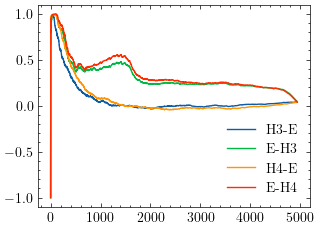

In [45]:
plt.plot(KendalltopK_H3E, label="H3-E")
plt.plot(KendalltopK_EH3, label="E-H3")
plt.plot(KendalltopK_H4E, label="H4-E")
plt.plot(KendalltopK_EH4, label="E-H4")

plt.legend()

#plt.savefig("Figures/k-step-comparison.png")